<div align="center">

# eqc-models

<h4>
  Wesley Dyk<br>
  <small style="font-weight: normal;">
    Senior Quantum Solutions Architect<br>
    Quantum Computing Inc.
  </small>
</h4>

<br>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qci-wdyk/eqc-models-tutorial/blob/main/tutorial01-programming.ipynb)

</div>


## Pseudocode for optimization
```
# Define a model instance
instance = OptModel()
# define a solver instance
solver = Solver()
# request a solution
response = solver.solve(model)
display_results(response)
```

## Pseudocode for machine learning
```
# Define a model instance
instance = MLModel()
# fit to training data
instance.fit(knownX, knownY)
# make predictions
y = instance.predict(unownX)
```



# Simple Optimization Model
## Two variable polynomial

$$
E = -x^2+2xy-y^2
$$

## Imports

In [29]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from eqc_models.base import PolynomialModel
from eqc_models.solvers.qciclient import Dirac1CloudSolver, Dirac3IntegerCloudSolver, Dirac3ContinuousCloudSolver

## API keys

In [ ]:
# Define the API URL and token  for QCI
api_url ="https://api.qci-prod.com"
api_token = "" # Replace with your actual API token

## Visualize

In [31]:
#  Create a 2D coordinate grid for x and y
numpoints = 20
xlist = np.linspace(0, 1, numpoints)
ylist = np.linspace(0, 1, numpoints)
x, y = np.meshgrid(xlist, ylist)

In [32]:
# Define the polynomial model
z = -x**2 + 2*x*y - y**2

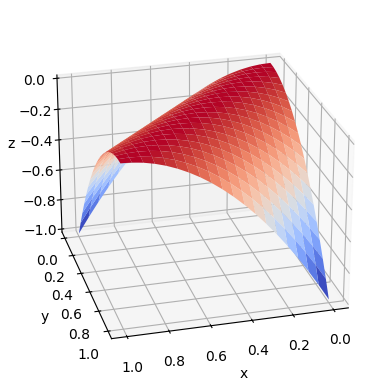

In [33]:
# Plot the 3D surface of the function z = -x**2 + 2*x*y - y**2
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
polycollection = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(25, 75)

## Model Definition
### 1. Defining the objective function
The polynomial objectivbe function `E` can be defined by combining two lists: `coefficients` and `variables`.
* `coefficients` : numurical multipliers for each term in the polynomial.
    ```python
    coefficients = [-1, 2, -1]
    ```
* `indices` : Each tuple in `indices` represent the variable and the power of variable in the polynomial. The elements of the tuple are variable indices, i.e., `1` means $x_1$, `2` means $x_2$. The length of the tuple is equal to the term's degree. Moreover the order
    ```python
    indices = [(1, 1), (1, 2), (2, 2)]
    ```

The `PolynomialModel` maps the `coefficients` to the `indices` in order, creating the full objective function:

$E = \underbrace{-1}_{\text{coef[0]}} \cdot \underbrace{x_1 x_1}_{\text{idx[0]}} + \underbrace{2}_{\text{coef[1]}} \cdot \underbrace{x_1 x_2}_{\text{idx[1]}} + \underbrace{-1}_{\text{coef[2]}} \cdot \underbrace{x_2 x_2}_{\text{idx[2]}}$

In [34]:
coefficients = [-1, 2, -1]
indices = [(1, 1), (1, 2), (2, 2)]
# Encodes -1*x^2 + 2*x*y - 1*y^2

### 2. Defining the model
After defining the objective function, we can create a model instance. The `PolynomialModel` takes the `coefficients` and `indices` as arguments.
Once the model is created, we can add bounds to the variables. The bounds are defined a list of tuples, where each tuple contains the upper bounds for each variable. The bounds are applied to the variables in the order they are defined in the `indices` list.


In [ ]:
# Define the polynomial model
model = PolynomialModel(coefficients, indices)
model.upper_bound = np.ones((2, ))

By setting the upper bounds using `model.upper_bounds`, the upper bounds for `x` and `y` are set to 1. 

## Dirac-3

To address a variety of optimization models, Dirac-3 offers three specialized Cloud solvers: `Dirac3IntegerCloudSolver`, `Dirac3ContinuousCloudSolver`, and `Dirac3MIPCloudSolver`.

In [36]:
# Connect to the QCi Integer Cloud Solver
solver = Dirac3IntegerCloudSolver(url=api_url, api_token=api_token)

In [38]:
# Request the solution from the solver
response = solver.solve(model)

# Print the results
print(response)

2025-08-14 15:35:35 - Dirac allocation balance = 9645 s (unmetered)
2025-08-14 15:35:35 - Job submitted: job_id='689e3a868060c93397963096'
2025-08-14 15:35:35 - QUEUED
2025-08-14 15:40:11 - RUNNING
2025-08-14 15:40:14 - COMPLETED
2025-08-14 15:40:17 - Dirac allocation balance = 9645 s (unmetered)
{'job_info': {'job_id': '689e3a868060c93397963096', 'job_submission': {'problem_config': {'qudit_hamiltonian_optimization': {'polynomial_file_id': '689e3a86acc178773e9a1b02'}}, 'device_config': {'dirac-3_qudit': {'num_levels': [2, 2], 'num_samples': 1, 'relaxation_schedule': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-08-14T19:35:34.585Z', 'queued_at_rfc3339nano': '2025-08-14T19:35:34.586Z', 'running_at_rfc3339nano': '2025-08-14T19:40:10.663Z', 'completed_at_rfc3339nano': '2025-08-14T19:40:12.605Z'}, 'job_result': {'file_id': '689e3b9cacc178773e9a1b0d', 'device_usage_s': 1}}, 'status': 'COMPLETED', 'results': {'counts': [1], 'energies': [-1], 'solutions': [[0, 1]]}}


In [39]:
# Extract the solutions from the response
response["results"]["solutions"]

[[0, 1]]

The Dirac-3 integer solver `Dirac3IntegerCloudSolver` leverages the `num_samples` argument within the `solver.solve()` method to produce a specified number of unique solutions for a given problem.
<!-- * `sum_constraint`: A required numerical value for the constraint on the sum of all variables. For the given example, the sum of `x` and `y` must equal 1.
* `relaxation_schedule`: An integer from the set `{1, 2, 3, 4}` representing one of four predefined schedules. Higher values reduce variation in the analog spin values during the solving process and are more likely to result in a better objective function value. -->

In [41]:
response = solver.solve(model, num_samples=5) #, sum_constraint=1, relaxation_schedule=1)

2025-08-14 15:45:03 - Dirac allocation balance = 9645 s (unmetered)
2025-08-14 15:45:04 - Job submitted: job_id='689e3cbf8060c9339796309d'
2025-08-14 15:45:04 - QUEUED
2025-08-14 15:47:28 - RUNNING
2025-08-14 15:47:31 - COMPLETED
2025-08-14 15:47:33 - Dirac allocation balance = 9645 s (unmetered)


In [42]:
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

Solutions: [[1, 0]] Counts: [5]


We can also use the `Dirac1CloudSolver` to solve the model.

In [43]:
solver = Dirac1CloudSolver(url=api_url, api_token=api_token)
response = solver.solve(model, num_samples=5)
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

2025-08-14 15:52:57 - Dirac allocation balance = 9645 s (unmetered)
2025-08-14 15:52:57 - Job submitted: job_id='689e3e998060c933979630a4'
2025-08-14 15:52:58 - QUEUED
2025-08-14 15:53:00 - RUNNING
2025-08-14 15:54:05 - COMPLETED
2025-08-14 15:54:07 - Dirac allocation balance = 9645 s (unmetered)
Solutions: [[1, 0], [0, 1]] Counts: [4, 1]


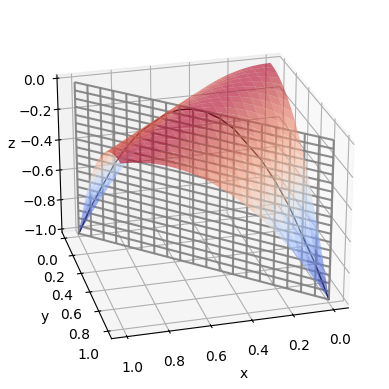

In [44]:
# Define the coordinates for a flat plane where x + y = 1 
xsel = np.linspace(0, 1, numpoints)
zsel = np.linspace(-1, 0, numpoints)
xsel, zsel = np.meshgrid(xsel, zsel)
ysel = 1 - xsel

# Create the 3D plot and add the visual elements
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# z = -x**2 + 2*x*y - y**2
polycollection1 = ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.6)

# x + y = 1 plane
polycollection2 = ax.plot_wireframe(xsel, ysel, zsel, color='gray', alpha=0.9)
sel = x + y == 1
xsel = x[sel]
ysel = y[sel]
zsel = z[sel]

# Intersection line
ax.plot(xsel, ysel, zsel, linewidth=1, color='black')

# Format the plot
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(25, 75)

The `Dirac3ContinuousCloudSolver` can find optimal solutions for problems with continuous variables, requiring a mandatory `sum_constraint` to define the valid solution space.
This figure illustrates how the mandatory `sum_constraint` defines a plane (the gray wireframe) that slices through the objective function's surface (colored), forcing the continuous solver to find the optimal solution along their line of intersection.

In [46]:
solver = Dirac3ContinuousCloudSolver(url=api_url, api_token=api_token)
response = solver.solve(model, sum_constraint=1, relaxation_schedule=1, num_samples=5) #, solution_precision=0.1)
print("Solutions:", response["results"]["solutions"], "Counts:", response["results"]["counts"])

2025-08-14 15:58:27 - Dirac allocation balance = 9645 s (unmetered)
2025-08-14 15:58:27 - Job submitted: job_id='689e3fe28060c933979630a9'
2025-08-14 15:58:27 - QUEUED
2025-08-14 15:59:26 - RUNNING
2025-08-14 15:59:29 - COMPLETED
2025-08-14 15:59:32 - Dirac allocation balance = 9645 s (unmetered)
Solutions: [[1, 0], [0, 1]] Counts: [4, 1]


# Simple Classification Model

<div align="center">

| X1 | X2 | Y |
|----|----|---|
| 0.25 | 0.25 | -1 |
| 0.75 | 0.25 | -1 |
| 0.75 | 0.75 | 1 |
| 0.5 | 0 | -1 |
| 0.5 | 1 | 1 |
| 1 | 1 | 1 |

</div>

The given table presents a small training dataset where the goal is to predict the label `Y` based on the features `X1` and `X2`.
In this example, the model would learn a decision boundary to separate the `-1` class from the `1` class based on the `(X1, X2)` coordinate pairs.
The `eqc-models` library provides the `QBoostClassifier`, a suite of tools for **Quantum Machine Learning** (QML) that can be used to train a model on this dataset.

In [48]:
# Import the QBoostClassifier from eqc_models.ml.classifierqboost
from eqc_models.ml.classifierqboost import QBoostClassifier

The training data set is given.
`X` contains the input features for each data point and `y` holds the corresponding binary class labels `(-1 or 1)` that the QBoost model will learn to predict.

In [49]:
X = np.array([[ 0.25, 0.25],
              [0.75, 0.25],
              [0.75, 0.75],
              [0.5, 0],
              [0.5, 1],
             [1, 1]])
y = np.array([-1, -1, 1, -1, 1, 1])

The `QBoostClassifier` is initialized with several key arguments that control the behavior of the underlying quantum-inspired solver and the boosting algorithm itself.
* `num_samples` : Specifies the number of independent solutions (samples) to be generated by the solver.
* `relaxation_schedule` : An integer from the set `{1, 2, 3, 4}` representing one of four predefined schedules.
* `lambda_coeff` : The regularization coefficient (lambda, λ). This parameter is crucial for preventing overfitting. It adds a penalty to the objective function that discourages overly complex models, helping the model generalize better to new, unseen data.
* `week_cls_strategy` : Defines the strategy used to train the set of weak classifiers that are combined to form the final strong classifier.

In [50]:
qboost = QBoostClassifier(num_samples=1,relaxation_schedule=1,lambda_coef=0.0, weak_cls_strategy="sequential")

We can train the `qboost` model by teaching it to find the relationship between the input features (`X`) and their corresponding output labels (`y`).

In [51]:
qboost.fit(X, y)

Runtime of _build_weak_classifiers_sq: 0.00 seconds!
Built 2 weak classifiers!
Runtime of get_hamiltonian: 0.00 seconds!
2025-08-14 16:16:40 - Dirac allocation balance = 9645 s (unmetered)
2025-08-14 16:16:40 - Job submitted: job_id='689e44278060c933979630b2'
2025-08-14 16:16:40 - QUEUED
2025-08-14 16:19:43 - RUNNING
2025-08-14 16:19:46 - COMPLETED
2025-08-14 16:19:48 - Dirac allocation balance = 9645 s (unmetered)
{'job_info': {'job_id': '689e44278060c933979630b2', 'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '689e4427acc178773e9a1b8a'}}, 'device_config': {'dirac-3_normalized_qudit': {'num_samples': 1, 'relaxation_schedule': 1, 'sum_constraint': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-08-14T20:16:39.453Z', 'queued_at_rfc3339nano': '2025-08-14T20:16:39.454Z', 'running_at_rfc3339nano': '2025-08-14T20:19:42.238Z', 'completed_at_rfc3339nano': '2025-08-14T20:19:43.07Z'}, 'job_result': {'file_id': '689e44dfacc178773

{'job_info': {'job_id': '689e44278060c933979630b2',
  'job_submission': {'problem_config': {'normalized_qudit_hamiltonian_optimization': {'polynomial_file_id': '689e4427acc178773e9a1b8a'}},
   'device_config': {'dirac-3_normalized_qudit': {'num_samples': 1,
     'relaxation_schedule': 1,
     'sum_constraint': 1}}},
  'job_status': {'submitted_at_rfc3339nano': '2025-08-14T20:16:39.453Z',
   'queued_at_rfc3339nano': '2025-08-14T20:16:39.454Z',
   'running_at_rfc3339nano': '2025-08-14T20:19:42.238Z',
   'completed_at_rfc3339nano': '2025-08-14T20:19:43.07Z'},
  'job_result': {'file_id': '689e44dfacc178773e9a1bf2', 'device_usage_s': 1}},
 'status': 'COMPLETED',
 'results': {'counts': [1],
  'energies': [-6],
  'solutions': [[0.0001352, 0.9998648]]}}

After training, we can evaluate the model by generating predictions for the input data `X` and showing them alongside the known true labels `y` for a direct comparison.

In [ ]:
# Evaluate the model's predictions
qboost.predict(X), y

(array([-1., -1.,  1., -1.,  1.,  1.]), array([-1, -1,  1, -1,  1,  1]))

Also we can predict the class labels for a new set of five unseen data points that were not in the original training set.

In [ ]:
# new data points for prediction
qboost.predict(np.array([[1, 1], [0.2, 0.2], [0.6, 0.75], [1, 0], [0.6, 0.6]]))

array([ 1., -1.,  1., -1.,  1.])